In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from chunk_utils import *

data_dir = './data/names'
image_dir = './images/'

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
filenames = list(filter(lambda x: x.endswith('.kdt'), os.listdir(data_dir)))

In [4]:
fn = filenames[-4]

with open(data_dir+'//'+fn, 'r') as fh:
    filedata = fh.read()
typedname, rawkd = filedata.split('\n')
n_chars = len(typedname)

name_keys = get_phrases_from_rawkd(rawkd, typedname.lower())    
delays = np.array([keypress2delays(typedname, keys) for keys in name_keys])

typedname = typedname.replace(' ', '_')
keypairs = list(map(lambda x: x[0]+x[1], zip(typedname, typedname[1:])))
typedname

'ABHISHEK_SAHAI'

In [5]:
models = [KernelDensity() for  x in range(delays.shape[1])]
# for each key in the typed word..build a model
for i in range(delays.shape[1]):
    models[i].fit(delays[:,i].reshape(-1,1))

generated_delays = []

for i in range(20):
    generated_iter = [x.sample()[0][0] for x in models]
    generated_delays.append(generated_iter)
    
generated_delays = np.array(generated_delays)

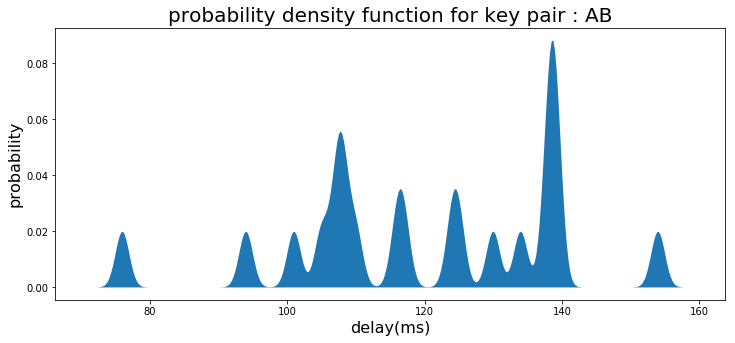

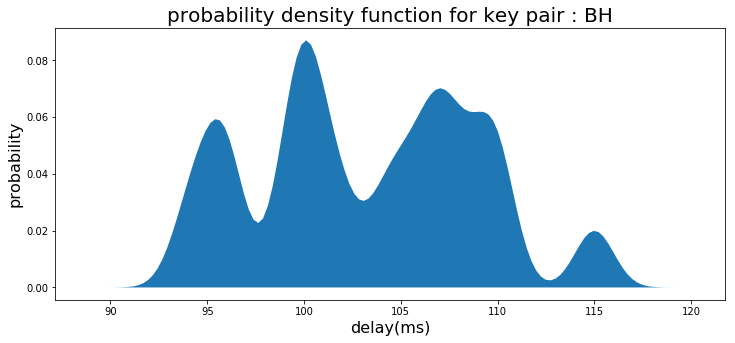

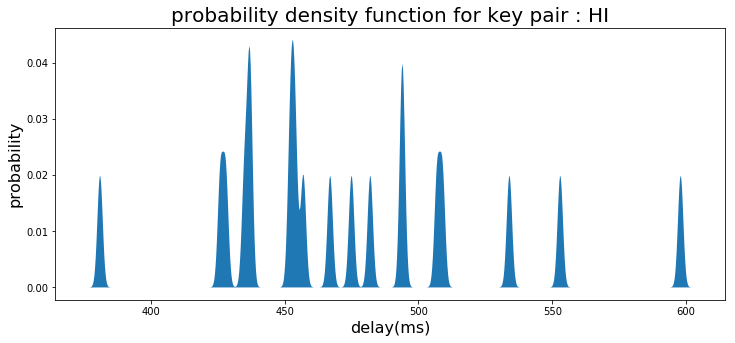

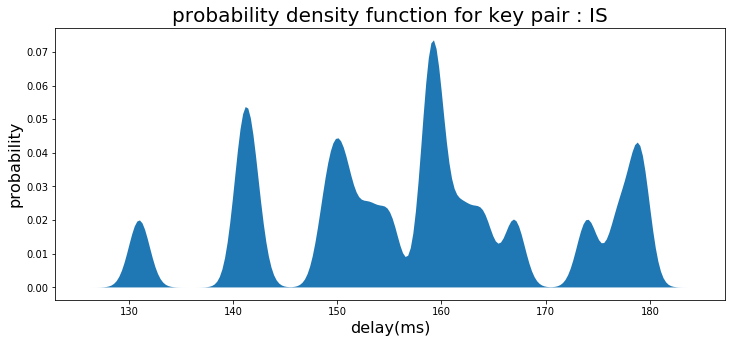

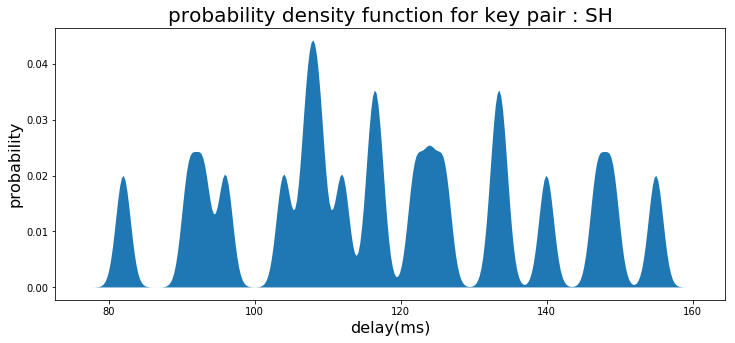

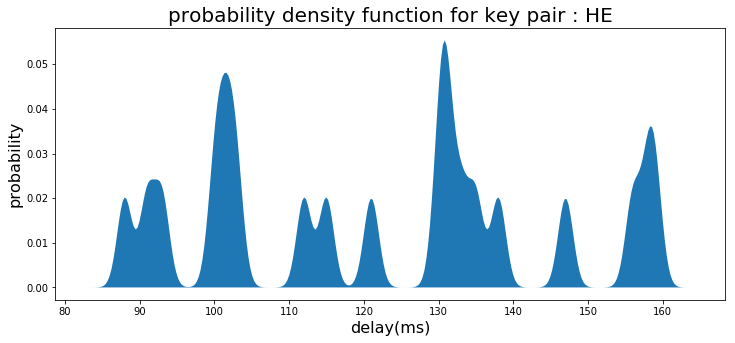

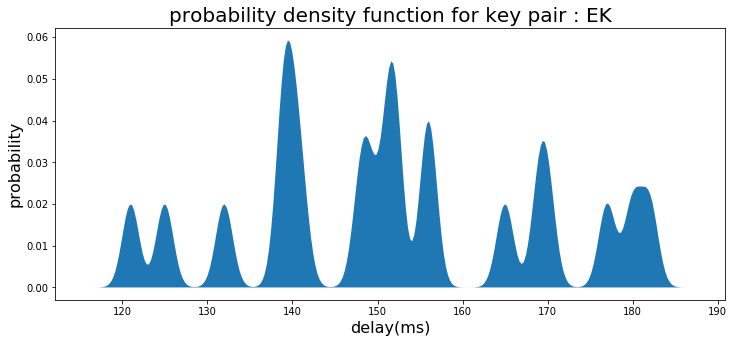

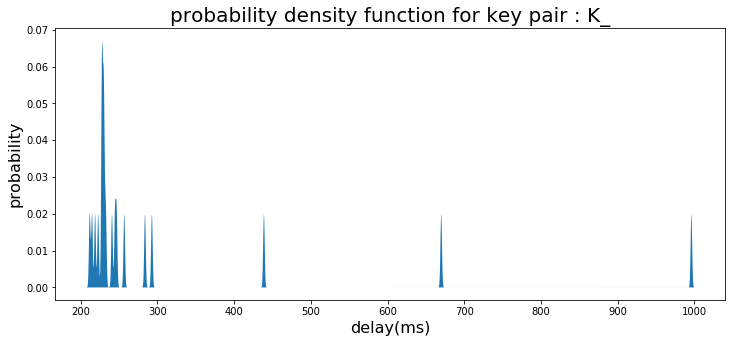

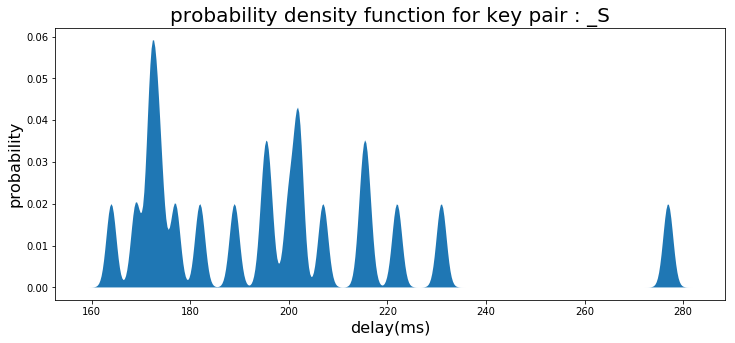

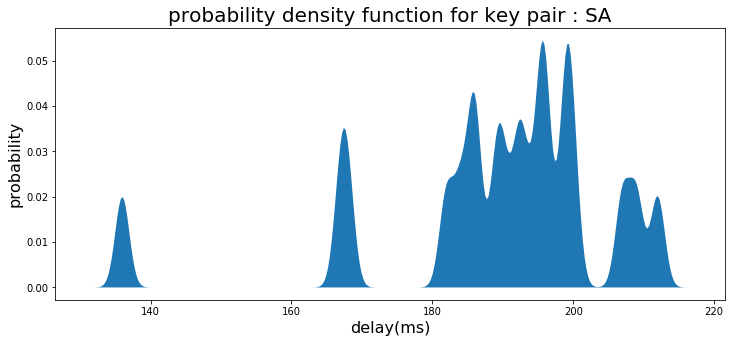

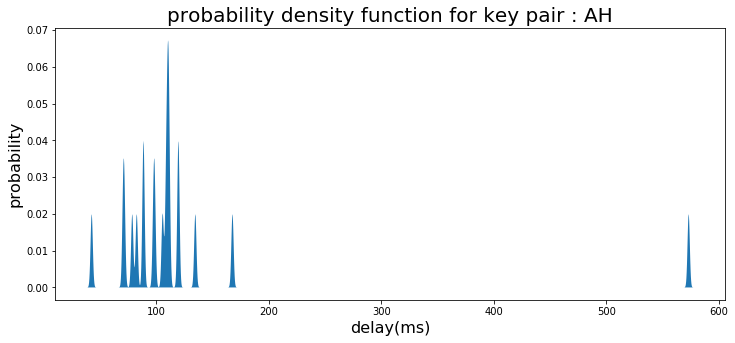

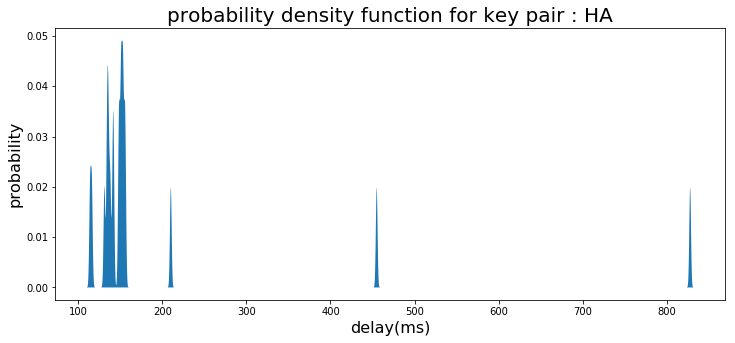

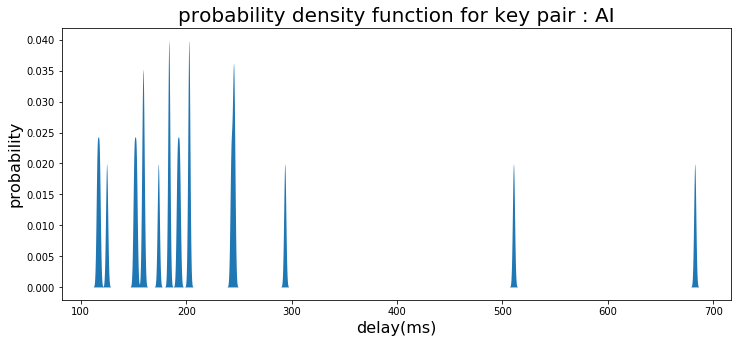

In [6]:
# find the probability density function for a key pair
matplotlib.rcParams['figure.figsize'] = 12,5

for keyIndex in range(len(typedname)-1):
    delayspace = np.linspace(10,1000,4000)

    logprobX = models[keyIndex].score_samples(delayspace.reshape(-1,1))
    prob = np.exp(logprobX)
    epsilon = 0.00000001
    nonzero_indx = prob>=epsilon
    prob_nonzero = prob[nonzero_indx]
    delayspace = delayspace[nonzero_indx]

    plt.fill(delayspace,prob_nonzero)
    #plt.fill(delayspace,prob)
    
    plt.title("probability density function for key pair : {}".format(keypairs[keyIndex]), fontsize=20)
    plt.xlabel('delay(ms)', fontsize=16)
    plt.ylabel('probability', fontsize=16)
    plt.show()

### let's plot them, side by side!

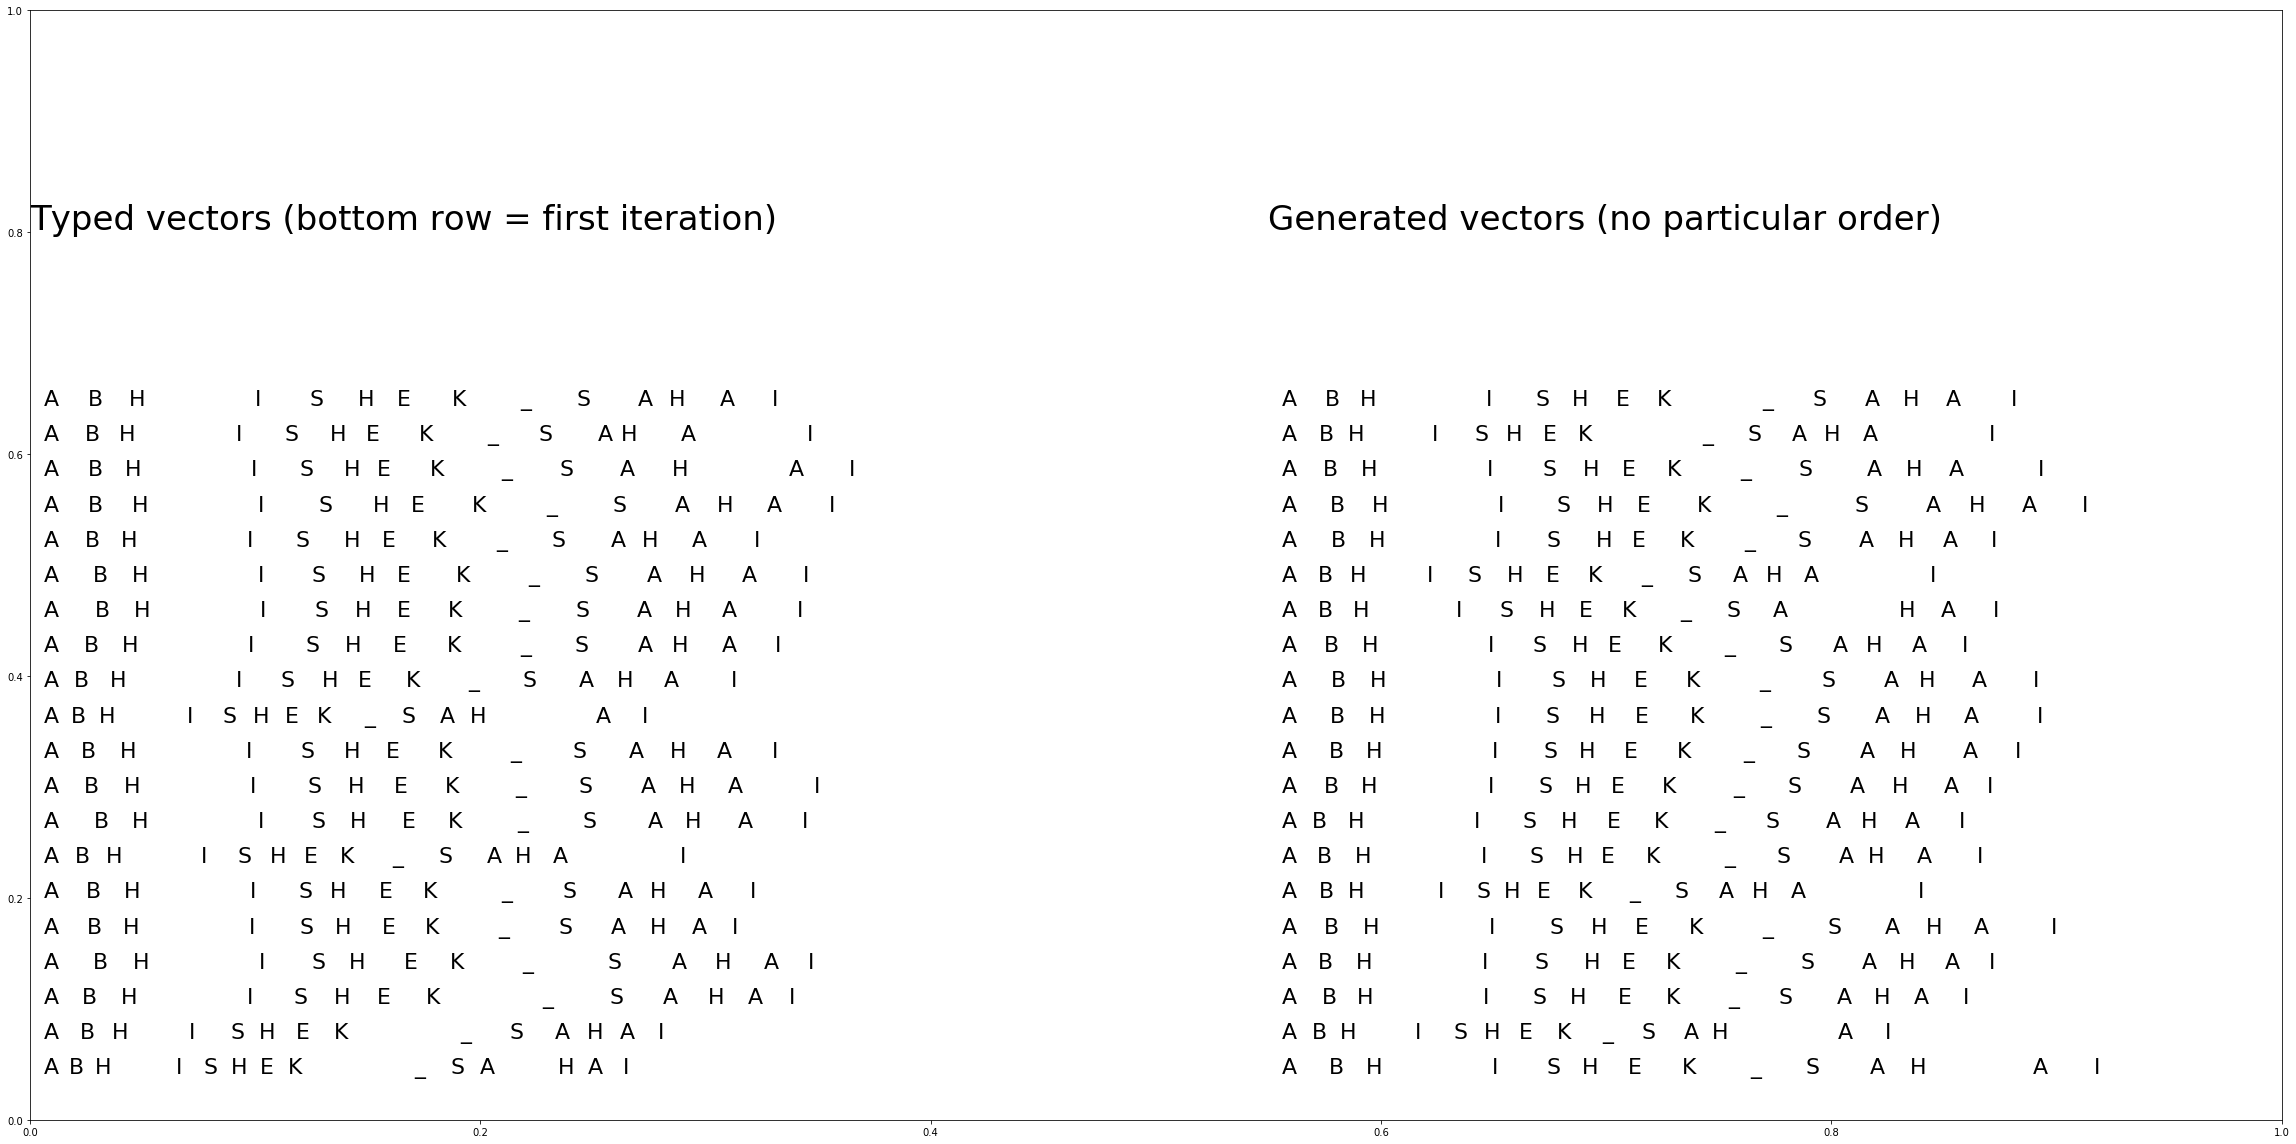

In [7]:
ypos = 0.01
ydelta = 0.0317


matplotlib.rcParams['figure.figsize'] = 32,16

for dd in generated_delays:
    xposvector = get_xpos_from_delays(dd, space_min = 0.006, max_delta_spacing=0.05, x_begin=0.55)
    for char, xpos in zip(typedname, xposvector):
        plt.text(xpos, ypos + ydelta, char, fontsize=22)
    ypos += ydelta
plt.text(0.55, ypos+5*ydelta, "Generated vectors (no particular order)", fontsize=34)
    
ypos = 0.01
for dd in delays:
    xposvector = get_xpos_from_delays(dd, space_min = 0.006, max_delta_spacing=0.05, x_begin=0.0)
    for char, xpos in zip(typedname, xposvector):
        plt.text(xpos, ypos + ydelta, char, fontsize=22)
    ypos += ydelta
plt.text(0.0, ypos+5*ydelta, "Typed vectors (bottom row = first iteration)", fontsize=34)


plt.tight_layout()
plt.show()
#plt.savefig(".//images//spatial_plot_" + typedname + "_.svg", format='svg')
#plt.close()

### discover clusters .. do they change over iterations?

In [8]:
from pyclustering.cluster.xmeans import xmeans

In [11]:
delays.shape, len(typedname)

((20, 13), 14)

In [29]:
tol = 0.001
for indx in range(delays.shape[0]):
    clus = xmeans(delays[indx].reshape(-1,1), tolerance = tol)
    clus.process()
    cids = clus.get_clusters()
    print (cids, len(cids))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12], [2], [7]] 3
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11], [2], [12]] 3
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12], [2], [11]] 3
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12], [2], [11]] 3
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 1
[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2]] 2


ok, so the xmeans on single vectors idea didn't work out.
### create separate KDE models for first 10 and last 10 iterations. then check whether those diverge